# 911 Response Time Analysis
## 🚀 Motivation
I want to understand how quickly the San Francisco Fire Department (FD) and Department of Emergency Management (DEM) respond medical 911 calls and see where improvements can be made to their response times.

## 🔍 Key Insights
- 65% of life threatening calls are responded to within 10 minutes.
- 70% of non-life threaning calls are responded to within 20 minutes.
- 80% of the response time is FD units getting to the scene.
- Outer regions of SF experience longer response times.

## 🔧 Recommendations
- Investigate factors that contribute to long driving times to the scene. Can ambulances be dispatched or allocated in more effective ways? And when they're on the road, what are the biggest blockers to them getting to the scene?
- Investigate what can be improved in how DEM works with FD to dispatch ambulances after receiving a call. What are the main roadblocks in this process?

## 📋 Table of contents
1. [Background](#background)
2. [About the data](#about-the-data)
3. [High level analytics](#high-level-analytics)
4. [Exploring slow response times](#exploring-slow-response-times)
5. [Breaking down response times](#breaking-down-response-times)
6. [Dispatching busy ambulances](#dispatching-busy-ambulances)
7. [Spatial analysis of driving times](#spatial-analysis-of-driving-times)
8. [Affect of hospital diversions on response times](#affect-of-hospital-diversions-on-response-times)
9. [Summary](#summary)

---
jupyter:
  hide-input: true
---


## Background
The life cycle of a 911 call:

![ambulance-response-process.png](./_static/ambulance-response-process.png)

*[source](https://www.sf.gov/data/ambulance-response-life-threatening-emergencies)*

According to the [2023 SF Annual Performance report](https://www.sf.gov/sites/default/files/2023-12/FY23APRfinal.pdf), FD responds to 80-90% of 911 calls requiring an ambulance, and their goal is respond in under 10 minutes for code 3 calls (life-threatening) and under 20 minutes for code 2 calls (non-life-threatening). Their definition of their response time is the "Roll/Response" time (see above, [source](https://www.sf.gov/data/ambulance-response-life-threatening-emergencies)), which is only a portion of the lifecycle of a 911 call. **However, if I'm the caller, I ultimately care about the entire duration between initating the call and when an ambulance arrives - the "Call Duration" time** (see above). In this project, I analyze DEM and FD's performance using this metric, which I'll call the "response time".


## About the data
[SFFD and EMS Dispatched Calls for Service](https://data.sfgov.org/Public-Safety/Fire-Department-and-Emergency-Medical-Services-Dis/nuek-vuh3/about_data) contains all the FD units that are dispatched for 911 calls for many years. In this analysis, I focus on the FD ambulances that get dispatched to life threatening (code 3) and non-life threatening (code 2) calls between January 2021 and August 2024.

To focus on high quality data, I also filter out data with the following characteristics:
- Missing latitude/longitude of the call
- Dispatches without timestamps
- Responses with negative response times
- Responses where the response time is greater than 2 hours.

In [1]:
from pylab import rcParams
rcParams['figure.figsize'] = 13, 6

In [2]:
import pandas as pd
raw = pd.read_parquet('raw_data_analysis/08122024-5yr.parquet')
df = raw[(raw.call_date.dt.year >= 2021)]
df['code'] = df.final_priority
df.loc[:,'on_scene_hour'] = df.on_scene_dttm.dt.hour
df.loc[:,'on_scene_day_of_week'] = df.on_scene_dttm.dt.dayofweek
from sklearn.preprocessing import StandardScaler
def add_norm_lat_long(df):
    lats, longs, slats, slongs = [], [], [], []
    for coord in df.case_location.values:
        if coord and 'coordinates' in coord:
            long, lat = coord['coordinates'][0], coord['coordinates'][1]
            slongs.append(long)
            slats.append(lat)
            longs.append(float(long))
            lats.append(float(lat))
        else:
            slongs.append(None)
            slats.append(None)
            longs.append(pd.NA)
            lats.append(pd.NA)
    df.loc[:,'lat'] = lats
    df.loc[:,'long'] = longs
    df.loc[:,'slat'] = slats
    df.loc[:,'slong'] = slongs
    

    df = df[df.lat.notnull() & df.long.notnull()]

    lat_long_scalar = StandardScaler()
    norm_lat_long = lat_long_scalar.fit_transform(df[['lat', 'long']])
    norm_lat_long_df = pd.DataFrame(norm_lat_long, columns=['norm_lat', 'norm_long'])
    norm_lat_long_df.index = df.index
    df_normed_lat_long = pd.concat([df, norm_lat_long_df], axis=1)
    
    return lat_long_scalar, df_normed_lat_long

lat_long_scalar, df = add_norm_lat_long(df)
df = df[df.lat.notnull() & df.long.notnull()]

/var/folders/h2/v02yh68x5vz3hbxw0mxbfpsw0000gn/T/ipykernel_6514/375549137.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['code'] = df.final_priority
/var/folders/h2/v02yh68x5vz3hbxw0mxbfpsw0000gn/T/ipykernel_6514/375549137.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'on_scene_hour'] = df.on_scene_dttm.dt.hour
/var/folders/h2/v02yh68x5vz3hbxw0mxbfpsw0000gn/T/ipykernel_6514/375549137.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [3]:
df['received_to_dispatch'] = (df.dispatch_dttm - df.received_dttm).dt.total_seconds() / 60
df['dispatch_to_response'] = (df.response_dttm - df.dispatch_dttm).dt.total_seconds() / 60
df['response_to_onscene'] = (df.on_scene_dttm - df.response_dttm).dt.total_seconds() / 60
df['received_to_onscene'] = (df.on_scene_dttm - df.received_dttm).dt.total_seconds() / 60
df = df[(df.received_to_dispatch >= 0) & (df.dispatch_to_response >= 0) & (df.response_to_onscene >= 0)]

## High level analytics
From Jan 2021 to Aug 2024, SFFD responded to 467,363 calls that needed an ambulance, or roughly 150-350 calls per day (see below). 66% (309,594) of these calls have a latitude/longitude and positive response times, so we'll focus our analysis on these calls from now on.

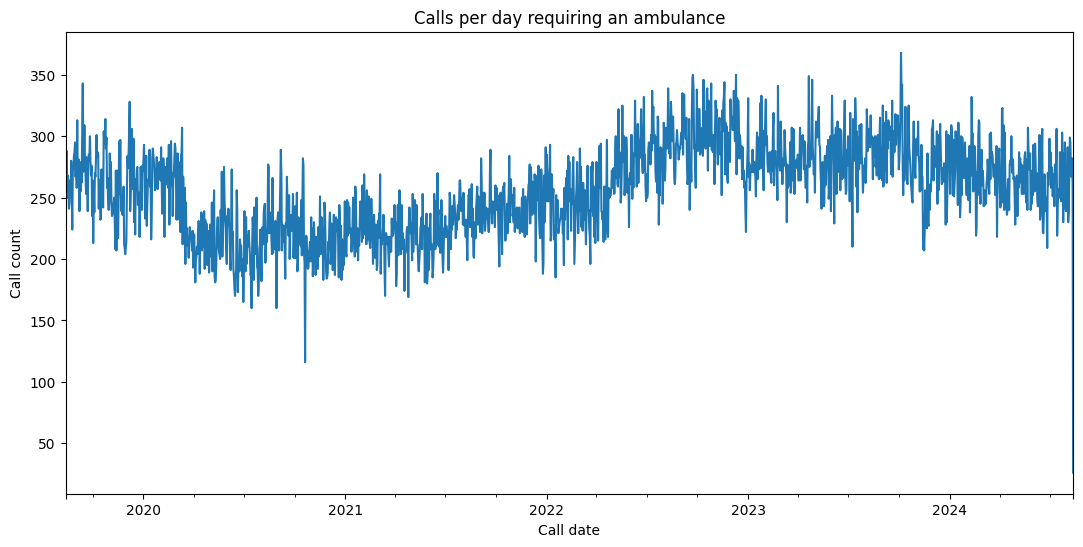

In [4]:
tmp = raw[raw.unit_type == 'MEDIC']
tmp.groupby('call_date').call_number.nunique().plot(
title='Calls per day requiring an ambulance',
xlabel='Call date',
ylabel='Call count');

Below shows quantiles of response times for code 3 (life threatening) and code 2 (non-life threatening) calls. As you can see, SFFD and SFDEM response to code 2 calls much slower than code 3 calls. At least part of this is due to ambulances driving without lights and sirens for these calls ([source](https://app.powerbigov.us/view?r=eyJrIjoiZWE0ZjE3OTEtYjE3Yi00YzJiLTgzOTEtOWU3ZGY2YzU4NTYwIiwidCI6IjIyZDVjMmNmLWNlM2UtNDQzZC05YTdmLWRmY2MwMjMxZjczZiJ9)).

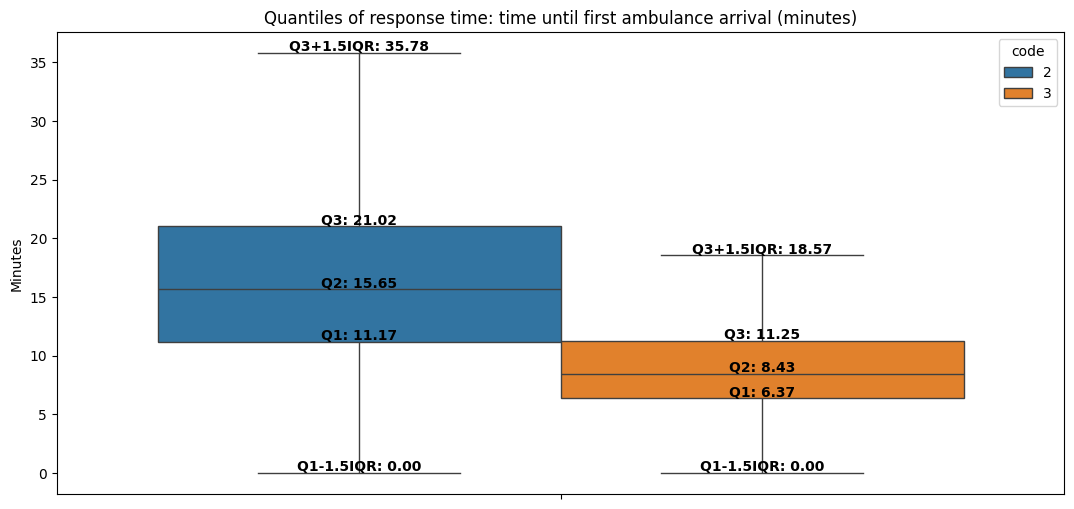

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
tmp = df[df.unit_type == 'MEDIC']
tmp = tmp.loc[tmp.groupby('incident_number')['dispatch_dttm'].idxmin()]
ax = sns.boxplot(tmp, y='received_to_onscene', hue='code', hue_order=['2', '3'], showfliers=False)

# Retrieve the lines that make up the boxplot
for i in range(2):
    # Get the whiskers and box information
    # Lines are ordered as: whisker_min, whisker_max, box_min, median, box_max
    whisker_low = ax.lines[i * 5].get_ydata()[1]
    whisker_high = ax.lines[i * 5 + 1].get_ydata()[1]
    q1 = ax.lines[i * 5].get_ydata()[0]
    median = ax.lines[i * 5 + 4].get_ydata()[0]
    q3 = ax.lines[i * 5 + 1].get_ydata()[0]

    # Get the center position for the label
    x_value = ax.lines[i * 5 + 3].get_xdata().mean()

    # Label each part with its value
    ax.text(x_value, median+0.5, f'Q2: {median:.2f}', ha='center', va='center', fontsize=10, fontweight='bold')
    ax.text(x_value, q1+0.5, f'Q1: {q1:.2f}', ha='center', va='center', fontsize=10, fontweight='bold')
    ax.text(x_value, q3+0.5, f'Q3: {q3:.2f}', ha='center', va='center', fontsize=10, fontweight='bold')
    ax.text(x_value, whisker_low+0.5, f'Q1-1.5IQR: {whisker_low:.2f}', ha='center', va='center', fontsize=10, fontweight='bold')
    ax.text(x_value, whisker_high+0.5, f'Q3+1.5IQR: {whisker_high:.2f}', ha='center', va='center',fontsize=10, fontweight='bold')


# Show the plot
plt.title('Quantiles of response time: time until first ambulance arrival (minutes)')
plt.ylabel('Minutes')
plt.show()

## Exploring slow response times
For this analysis, a call with a "slow" response time means that it took more than 10 minutes for the first ambulance to arrive on scene. As mentioned before, SFFD uses a similar metric by which to measure their response times. To ensure we're looking at high quality data, we'll also remove calls for which the response times is more than 2 hours, which is similar to how SF does their analysis ([source](https://www.sf.gov/data/response-times-911-calls#ambulance-code-3-vehicle-response)). **From now on, we'll only consider calls with late responses**.

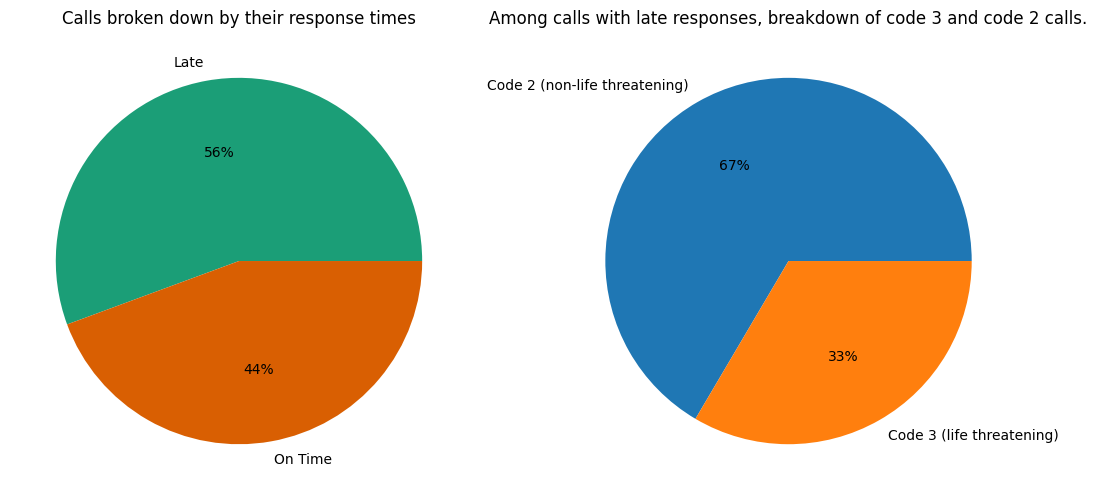

In [6]:
import seaborn as sns

tmp = df[df.unit_type == 'MEDIC']
tmp = tmp.loc[tmp.groupby('incident_number')['dispatch_dttm'].idxmin()]
medic = tmp[(tmp.received_to_onscene >= 10) & (tmp.received_to_onscene < 120)]
medic.unit_id.nunique()

fig, axs = plt.subplots(1,2)

axs[0].pie([len(medic),len(tmp[tmp.received_to_onscene < 10])], colors=sns.color_palette('Dark2'),
        autopct='%.0f%%', labels=['Late', 'On Time']);
axs[0].set_title('Calls broken down by their response times');

axs[1].pie([len(medic[medic.code == '2']),len(medic[medic.code == '3'])],
        colors=sns.color_palette('tab10'),
        autopct='%.0f%%', labels=['Code 2 (non-life threatening)', 'Code 3 (life threatening)']);
axs[1].set_title('Among calls with late responses, breakdown of code 3 and code 2 calls.');

In [7]:
df.loc[:,'received_hour'] = df.received_dttm.dt.hour
medic.loc[:,'received_hour'] = medic.received_dttm.dt.hour
df.loc[:,'received_day_of_week'] = df.received_dttm.dt.dayofweek
medic.loc[:,'received_day_of_week'] = medic.received_dttm.dt.dayofweek

/var/folders/h2/v02yh68x5vz3hbxw0mxbfpsw0000gn/T/ipykernel_6514/4013571862.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medic.loc[:,'received_hour'] = medic.received_dttm.dt.hour
/var/folders/h2/v02yh68x5vz3hbxw0mxbfpsw0000gn/T/ipykernel_6514/4013571862.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medic.loc[:,'received_day_of_week'] = medic.received_dttm.dt.dayofweek


As we can see below, there is a strong association between response times and volume of calls in that time period: Avg response times peak on friday when most calls during the week happen, and particularly between 10am and 6pm when most calls during a day happen.

/var/folders/h2/v02yh68x5vz3hbxw0mxbfpsw0000gn/T/ipykernel_6514/1186794475.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['unused','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])


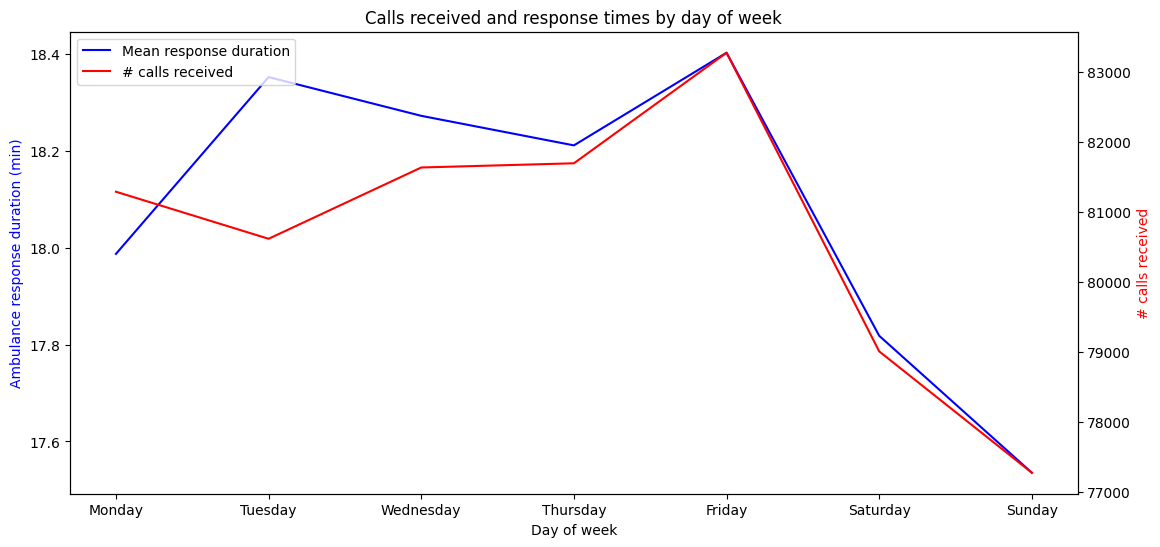

In [8]:
medic_onscene_day = medic.groupby('received_day_of_week').received_to_onscene.mean().to_frame().reset_index()
tmp = df.groupby('call_number').received_day_of_week.first().to_frame().reset_index()
df_call_count = tmp.groupby('received_day_of_week').size().to_frame(name='count').reset_index()

fig, ax1 = plt.subplots()

# Plot the first line plot
sns.lineplot(x='received_day_of_week', y='received_to_onscene', data=medic_onscene_day, ax=ax1, color='b',
             label='Mean response duration')

# Create a second y-axis with twinx
ax2 = ax1.twinx()

# Plot the second line plot on the second y-axis
sns.lineplot(x='received_day_of_week', y='count', data=df_call_count, ax=ax2, color='r', label='# calls received')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
ax2.get_legend().remove()
# Add labels for both y-axes

ax1.set_ylabel('Ambulance response duration (min)', color='b')
ax2.set_ylabel('# calls received', color='r')
ax1.set_xlabel('Day of week')
ax1.set_xticklabels(['unused','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Calls received and response times by day of week')
# Show the plot
plt.show()


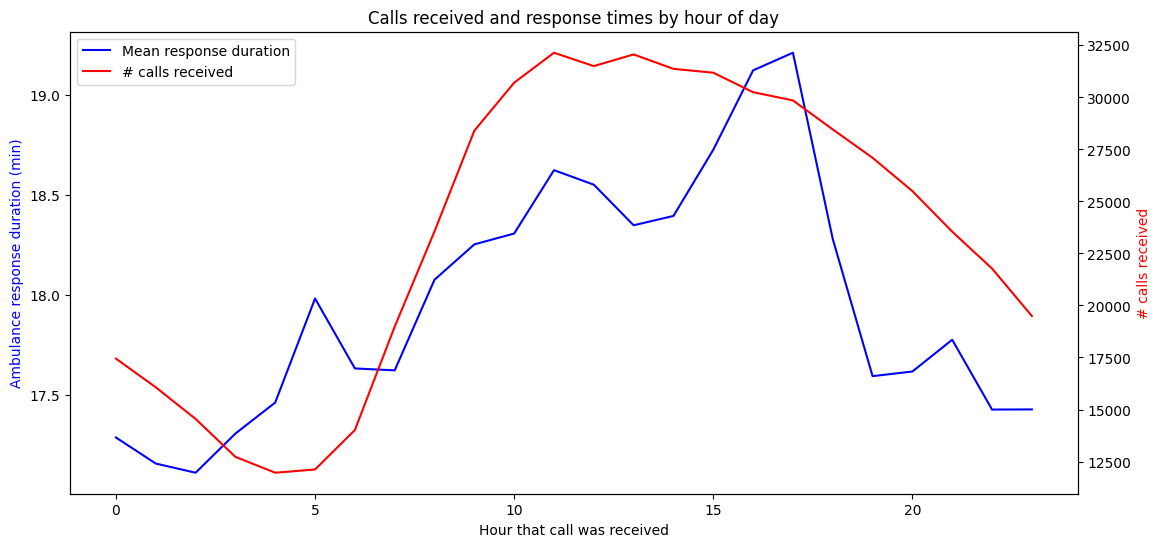

In [9]:
medic_onscene_hr = medic.groupby('received_hour').received_to_onscene.mean().to_frame().reset_index()
tmp = df.groupby('call_number').received_hour.first().to_frame().reset_index()
df_call_count = tmp.groupby('received_hour').size().to_frame(name='count').reset_index()

fig, ax1 = plt.subplots()

# Plot the first line plot
sns.lineplot(x='received_hour', y='received_to_onscene', data=medic_onscene_hr, ax=ax1, color='b',
             label='Mean response duration')

# Create a second y-axis with twinx
ax2 = ax1.twinx()

# Plot the second line plot on the second y-axis
sns.lineplot(x='received_hour', y='count', data=df_call_count, ax=ax2, color='r', label='# calls received')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
ax2.get_legend().remove()
# Add labels for both y-axes

ax1.set_ylabel('Ambulance response duration (min)', color='b')
ax2.set_ylabel('# calls received', color='r')
ax1.set_xlabel('Hour that call was received')
plt.title('Calls received and response times by hour of day')
# Show the plot
plt.show()

Additionally, the response time is very left skewed, so in general we will log transform the total response time in the visualizations

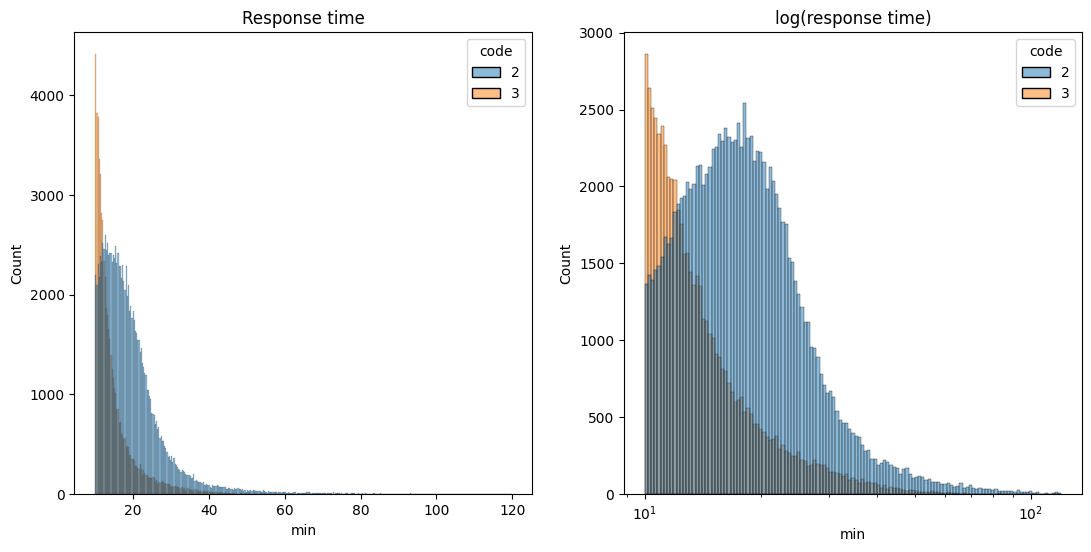

In [10]:
fix, axs = plt.subplots(1,2)
sns.histplot(medic, x='received_to_onscene', ax=axs[0], hue='code');
axs[0].set_title('Response time')
axs[0].set_xlabel('min')
sns.histplot(medic, x='received_to_onscene', ax=axs[1], log_scale=True, hue='code');
axs[1].set_title('log(response time)')
axs[1].set_xlabel('min');

## Breaking down response times
In the data, we have the following timestamps:
![response-time-breakdown.png](./_static/response-time-breakdown.png)
Let's visualize which stages take up the biggest portions of the total response time and how they're correlated with the total response time.

In [11]:
import numpy as np
medic['received_to_dispatch_perc'] = medic.received_to_dispatch * 100 / medic.received_to_onscene
medic['dispatch_to_response_perc'] = medic.dispatch_to_response * 100 / medic.received_to_onscene
medic['response_to_onscene_perc'] = medic.response_to_onscene * 100 / medic.received_to_onscene
medic['received_to_dispatch_log'] = np.log(medic.received_to_dispatch)
medic['dispatch_to_response_log'] = np.log(medic.dispatch_to_response)
medic['response_to_onscene_log'] = np.log(medic.response_to_onscene)
medic['received_to_onscene_log'] = np.log(medic.received_to_onscene)

/Users/domfj/Library/Caches/pypoetry/virtualenvs/sf-ff-service-KkBImDKy-py3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/domfj/Library/Caches/pypoetry/virtualenvs/sf-ff-service-KkBImDKy-py3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/domfj/Library/Caches/pypoetry/virtualenvs/sf-ff-service-KkBImDKy-py3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


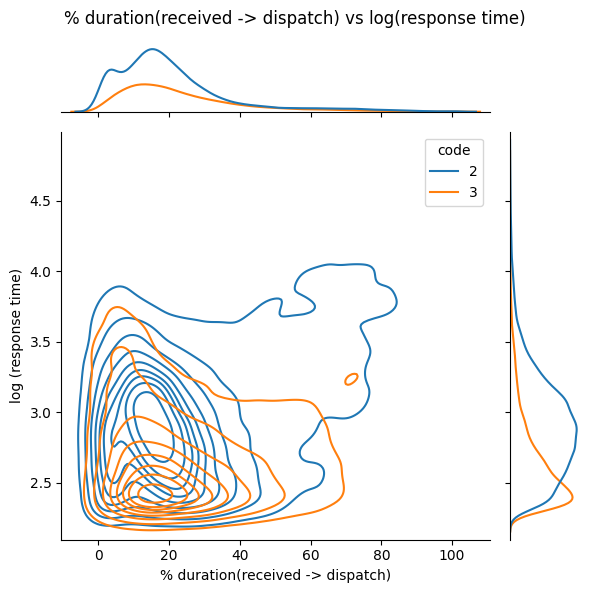

In [12]:
sns.jointplot(medic.sample(frac=0.2, random_state=0),
            x='received_to_dispatch_perc', y='received_to_onscene_log',
           hue='code', kind="kde", hue_order=['2', '3'])
plt.suptitle("% duration(received -> dispatch) vs log(response time)");
plt.xlabel('% duration(received -> dispatch)');
plt.ylabel('log (response time)');
plt.tight_layout();

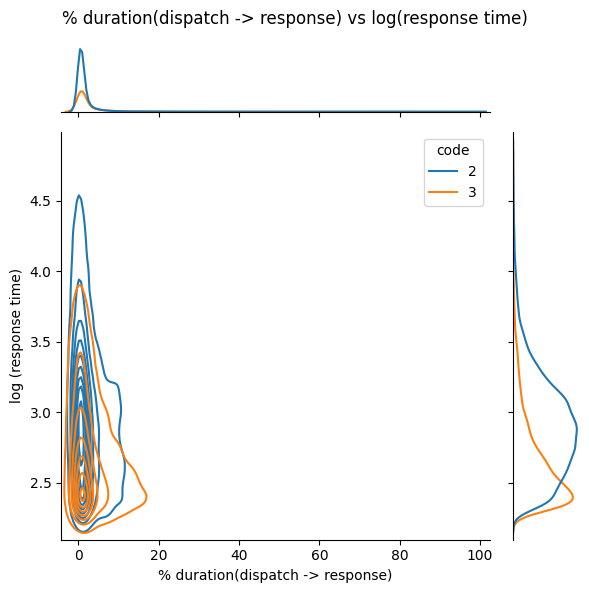

In [13]:
sns.jointplot(medic.sample(frac=0.2, random_state=0),
            x='dispatch_to_response_perc', y='received_to_onscene_log',
           kind='kde', hue='code', hue_order=['2', '3']);
plt.suptitle("% duration(dispatch -> response) vs log(response time)");
plt.xlabel('% duration(dispatch -> response)');
plt.ylabel('log (response time)');
plt.tight_layout();

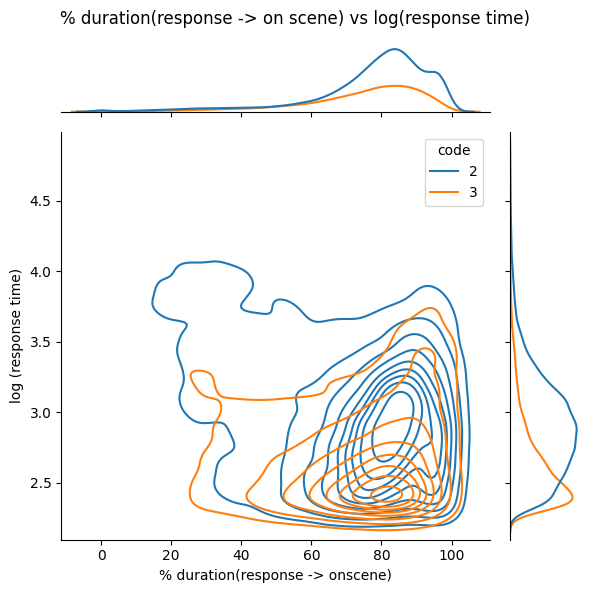

In [14]:
sns.jointplot(medic.sample(frac=0.2, random_state=0),
            x='response_to_onscene_perc', y='received_to_onscene_log',
           kind='kde', hue='code', hue_order=['2', '3']);
plt.suptitle("% duration(response -> on scene) vs log(response time)");
plt.xlabel('% duration(response -> onscene)');
plt.ylabel('log (response time)');
plt.tight_layout();

**Conclusion**: On average, 20% of the response time is spent receiving the call and dispatching an ambulance, and 80% is spent getting to the scene after acknowledging the dispatch. The time it takes for the ambulance to acknowledge the dispatch is negligible. There seems to be some correlation between these proportions and the total response time, especially for code 2 calls.

## Dispatching busy ambulances
For 8% of calls of slow repsonse times, the ambulance that was dispatched was not yet available when SFDEM received the call. Let's see this impact on the time it takes to dispatch an ambulance:

In [15]:
medic_sorted = medic.sort_values('received_dttm')
medic_sorted['prev_avail'] = None
for unit_id in medic_sorted.unit_id.unique():
    unit_filter = medic_sorted.unit_id == unit_id
    index_to_set = medic_sorted[unit_filter].iloc[1:].index
    prev_avail = medic_sorted[unit_filter].iloc[:-1].available_dttm
    prev_avail.index = index_to_set
    medic_sorted.loc[unit_filter, 'prev_avail'] = prev_avail
medic_sorted.prev_avail = pd.to_datetime(medic_sorted.prev_avail)
medic_sorted['prev_rest_min'] = (medic_sorted.received_dttm - medic_sorted.prev_avail).dt.total_seconds() / 60

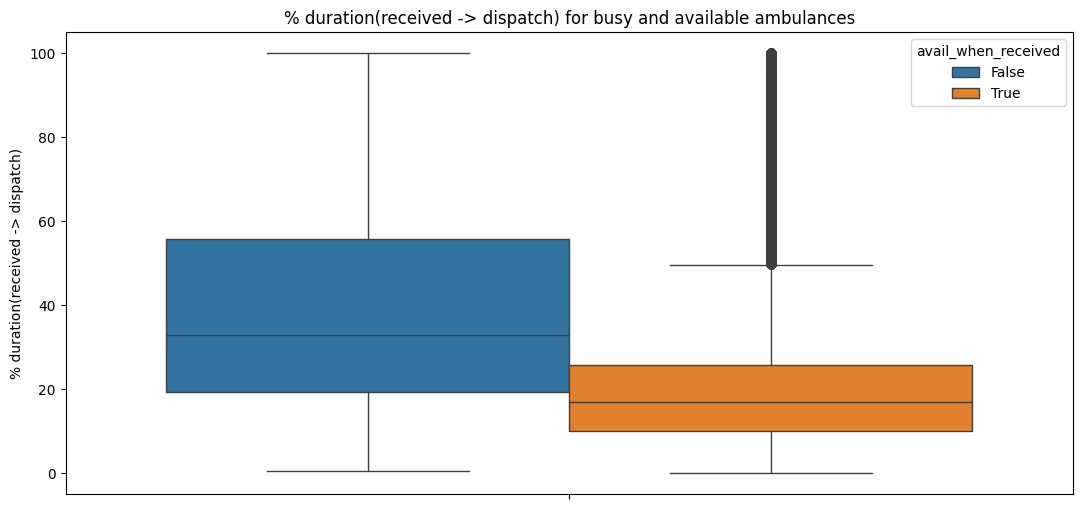

In [16]:
sum(medic_sorted.prev_rest_min < 0) / len(medic_sorted)
medic_sorted['avail_when_received'] = medic_sorted.prev_rest_min > 0
sns.boxplot(medic_sorted, y='received_to_dispatch_perc', hue='avail_when_received');
plt.title("% duration(received -> dispatch) for busy and available ambulances");
plt.ylabel('% duration(received -> dispatch)');

**Conclusion**: If an ambulance is not available by the time its next call is received, the % of that next call's response time taken up by simply dispatching the ambulance increases by 50% on average.

## Spatial analysis of driving times
![driving-time-breakdown.png](./_static/driving-time-breakdown.png)

Let's see if the duration of an ambulance responding to the scene are significantly different for different areas of SF. This may not entirely be due to driving, but I will call it "driving time" for simplicity. To split SF into different regions, I define 50 geographic regions using K-Means on the call locations. 50 was chosen because there are roughly that number of fire stations in SF, but the number itself is not important. Next, I display the top 15 clusters with the longest average response times (along with fire stations in green):

In [17]:
def dedup_calls(data, condition=None):
    if condition is not None:
        filtered = data[condition]
    else:
        filtered = data
    
    filtered.groupby(['slong', 'slat'])
    
    df = filtered.groupby(['slong', 'slat']).agg({
        'lat': 'mean',
        'long': 'mean',
    'norm_lat': ['mean','count'],
    'norm_long': 'mean',
        'received_to_onscene': 'mean'
    })
    df.columns = [' '.join(col).strip() for col in df.columns.values]
    df = df.rename(columns={'norm_lat mean': 'norm_lat', 'norm_lat count': 'count', 'norm_long mean': 'norm_long',
                           'lat mean': 'lat', 'long mean': 'long', 'received_to_onscene mean': 'received_to_onscene'})
    df['count'] *= df['received_to_onscene']
    return df

/var/folders/h2/v02yh68x5vz3hbxw0mxbfpsw0000gn/T/ipykernel_6514/676643172.py:6: UserWarning: 
The palette list has fewer values (15) than needed (50) and will cycle, which may produce an uninterpretable plot.
  ax = sns.scatterplot(pd.concat([x, preds], axis=1), x='norm_long', y='norm_lat', hue='cluster', palette = sns.color_palette("hls", 15));


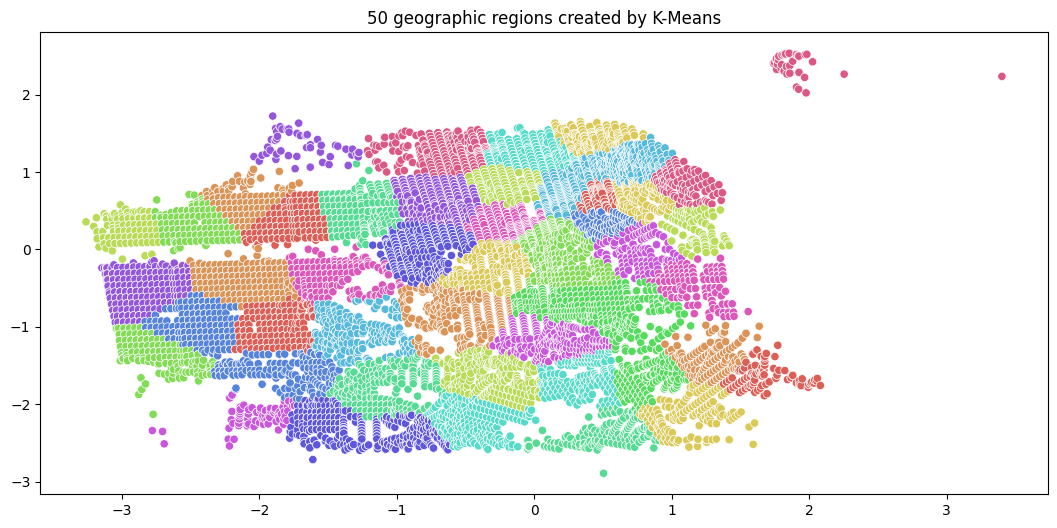

In [18]:
from sklearn import cluster
x = dedup_calls(medic_sorted)
km = cluster.KMeans(n_clusters=50, random_state=0)
preds = pd.Series(km.fit_predict(x[['norm_lat', 'norm_long']], sample_weight=x['count'])).to_frame(name='cluster')
preds.index = x.index
ax = sns.scatterplot(pd.concat([x, preds], axis=1), x='norm_long', y='norm_lat', hue='cluster', palette = sns.color_palette("hls", 15));
ax.get_legend().remove();
plt.title('50 geographic regions created by K-Means');
plt.xlabel('');
plt.ylabel('');

In [19]:
medic_sorted_clustered = pd.merge(medic_sorted, preds, on=['slong', 'slat'])
assert len(medic_sorted) == len(medic_sorted_clustered)
assert medic_sorted.shape[1] + 1 == medic_sorted_clustered.shape[1]

In [20]:
import geopandas as gpd
nhoods = gpd.read_file('raw_data_analysis/Analysis Neighborhoods.geojson')
stations = pd.read_csv('raw_data_analysis/stations.csv')

In [31]:
def show_clusters(data, condition, title, ax):
    data = data.copy()[condition]
    cluster_metrics = data.groupby('cluster').response_to_onscene.mean() 
    ordered_clusters = list(cluster_metrics.sort_values().index)
    nhoods.boundary.plot(ax=ax, edgecolor='black', linewidth=1, aspect=1)
    data = data[data.cluster.isin(ordered_clusters[-15:])]
    data = data.sample(frac=0.2, random_state=0)
    sns.scatterplot(data, x='long', y='lat', hue='cluster', ax=ax)
    sns.scatterplot(stations, x='long', y='lat', color='green', ax=ax)
    ax.set_xlim(-122.52, -122.32)
    ax.set_ylim(37.7088, 37.85)
    ax.set_ylabel('Latitude')
    ax.set_xlabel('Longitude')
    ax.set_title(title)
    ax.get_legend().remove()

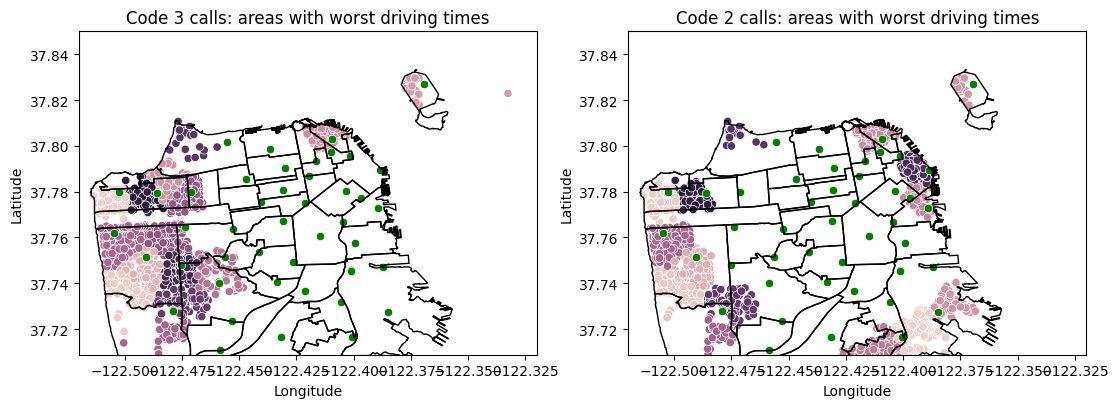

In [32]:
fig, axs = plt.subplots(1, 2)
show_clusters(medic_sorted_clustered, medic_sorted_clustered.code == '3',
             'Code 3 calls: areas with worst driving times', axs[0])
show_clusters(medic_sorted_clustered, medic_sorted_clustered.code == '2',
             'Code 2 calls: areas with worst driving times', axs[1])

In [23]:
from scipy.stats import permutation_test

def run_permutation_test(data, condition):
    data = data.copy()[condition]
    cluster_metrics = data.groupby('cluster').response_to_onscene.mean() 
    ordered_clusters = list(cluster_metrics.sort_values().index)    
    
    data['worst_clusters'] = data.cluster.isin(ordered_clusters[-15:])
    sampled = data.sample(frac=0.1, random_state=0)
    group1 = sampled[sampled.worst_clusters].response_to_onscene
    group2 = sampled[~sampled.worst_clusters].response_to_onscene

    # Run the permutation test
    result = permutation_test((group1, group2), 
                              statistic=lambda x, y: np.mean(x) - np.mean(y), 
                              n_resamples=10000,  # Monte Carlo approximation with 10,000 resamples
                              alternative='greater')
    print(f'p-value: {result.pvalue}')

In [24]:
print(f'Code 2 calls: permutation test for difference in mean driving time between worst areas vs others:')
run_permutation_test(medic_sorted_clustered, medic_sorted_clustered.code == '2')
print()
print(f'Code 3 calls: permutation test for difference in mean driving time between worst areas vs others:')
run_permutation_test(medic_sorted_clustered, medic_sorted_clustered.code == '3')

Code 2 calls: permutation test for difference in mean driving time between worst areas vs others:
p-value: 9.999000099990002e-05

Code 3 calls: permutation test for difference in mean driving time between worst areas vs others:
p-value: 9.999000099990002e-05


**Conclusion**: the areas with the worse driving times are all on the outskirts of the city (everywhere outside of the enclosed black lines is the Pacific Ocean / SF bay), which are also the areas with lower population density, lower volume of 911 calls, and lower density of fire stations.

A couple of notes:
1. I used a permutation test to test if the difference in means is significant in order to avoid making parametric assumptions in my data, which are not normally distributed.  
2. In this analysis, I did not weight driving times by the population or amount of calls in a given geographic area. In my perspective, this is one way to promote equity; SF's EMS system should be

## Affect of hospital diversions on response times
Hospitals can declare "ambulance diversion status", which prevents more ambulances arriving to that hospital (except for specialty cases). This [dataset](https://data.sfgov.org/Health-and-Social-Services/Hospital-Diversions/t4sf-777q/about_data) contains all declarations of diversion status since 2023. Let's see if hospital diversions affect subsequent call response times due to slowing down ambulances that need to transport patients to a hospital. To run this analysis, I do the following:
1. Get the number of hospitals on diversion status for each 30 min interval for which we have data (Jan 2023 - Aug 2024)
2. For each call, record the number of hospital diversions there were when the call was received (the current period) and 30 minutes before the call was received (the previous period).

In [25]:
diversions = pd.read_parquet('raw_data_analysis/hospital_diversions.parquet')

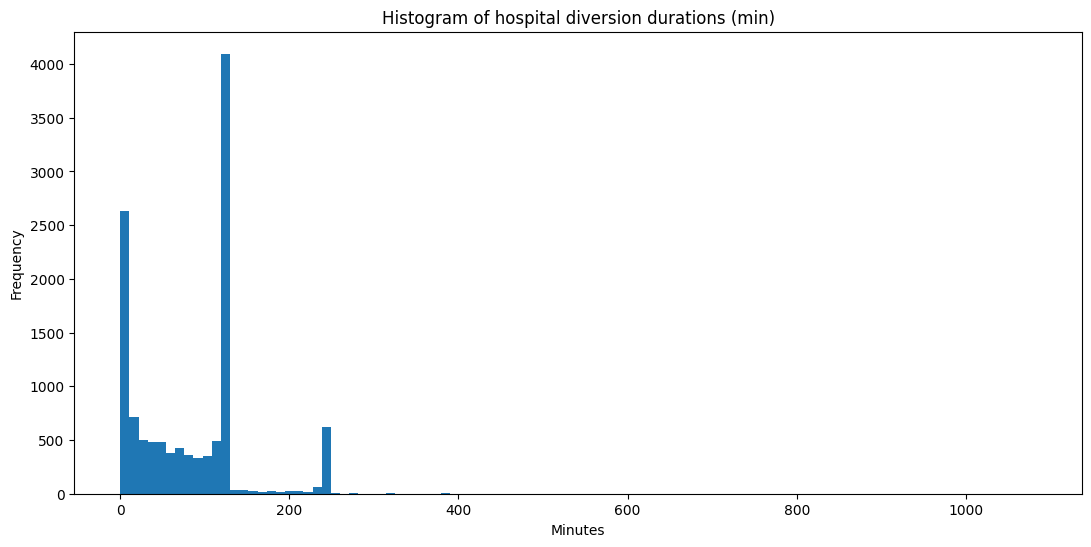

In [26]:
diversions.duration_in_minutes = diversions.duration_in_minutes.astype(float)
diversions.duration_in_minutes.plot.hist(bins=100,
                                         title='Histogram of hospital diversion durations (min)',
                                        xlabel='Minutes');

In [27]:
# Define the range of hours you want to analyze
all_periods = pd.date_range(start=diversions['started'].min().floor('30T'), 
                          end=diversions['ended'].max().ceil('30T'), freq='30T')

# Create a DataFrame to store the number of hospitals in diversion each hour
diversion_counts = pd.DataFrame({'period': all_periods})

# For each hour, count the number of hospitals that are in diversion
diversion_counts['diversion_count'] = diversion_counts['period'].apply(
    lambda h: np.sum((diversions['started'] <= h) & (diversions['ended'] > h))
)

/var/folders/h2/v02yh68x5vz3hbxw0mxbfpsw0000gn/T/ipykernel_3864/925204955.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  all_periods = pd.date_range(start=diversions['started'].min().floor('30T'),
/var/folders/h2/v02yh68x5vz3hbxw0mxbfpsw0000gn/T/ipykernel_3864/925204955.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  end=diversions['ended'].max().ceil('30T'), freq='30T')


In [28]:
medic_sorted['received_30T'] = medic_sorted.received_dttm.dt.floor('30min')
medic_sorted['received_30T_prev'] = medic_sorted.received_30T - pd.Timedelta(minutes=30)

In [29]:
medic_sorted_with_diversions = medic_sorted.merge(diversion_counts, how='inner',
                                        left_on='received_30T', right_on='period')
medic_sorted_with_diversions = medic_sorted_with_diversions.merge(diversion_counts, how='inner',
                                        left_on='received_30T_prev', right_on='period',
                                        suffixes=('_curr', '_prev'))

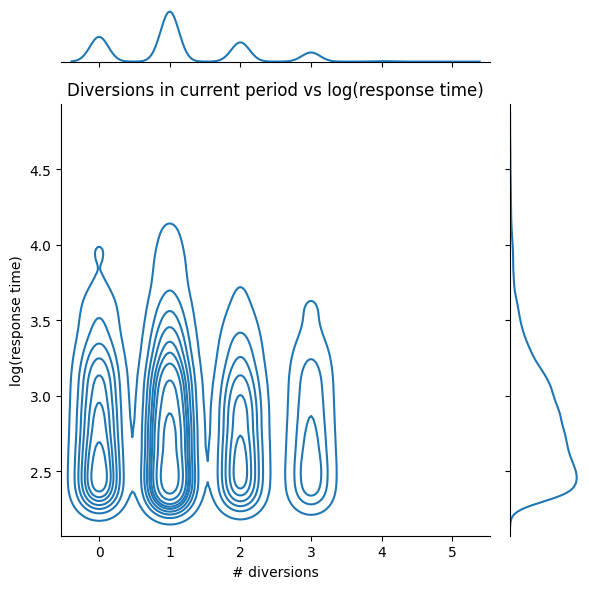

In [30]:
sns.jointplot(medic_sorted_with_diversions.sample(frac=0.2, random_state=0), x='diversion_count_curr',
             y='received_to_onscene_log', kind='kde');
plt.title('Diversions in current period vs log(response time)');
plt.xlabel('# diversions');
plt.ylabel('log(response time)');
plt.tight_layout()

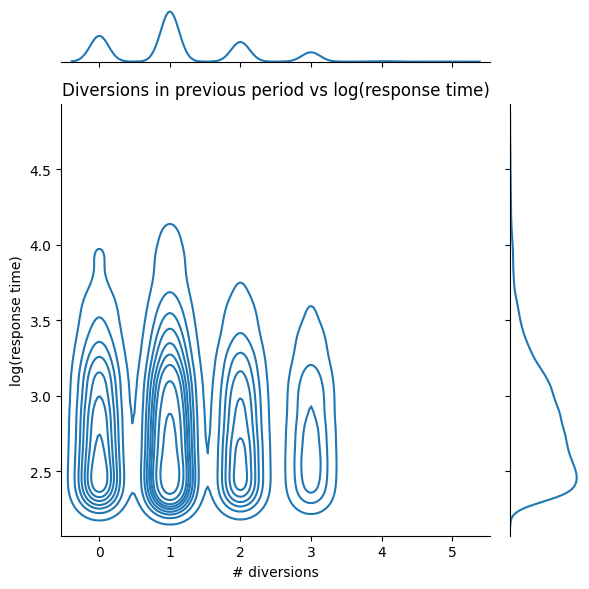

In [31]:
sns.jointplot(medic_sorted_with_diversions.sample(frac=0.2, random_state=0), x='diversion_count_prev',
             y='received_to_onscene_log', kind='kde');
plt.title('Diversions in previous period vs log(response time)');
plt.xlabel('# diversions');
plt.ylabel('log(response time)');
plt.tight_layout()

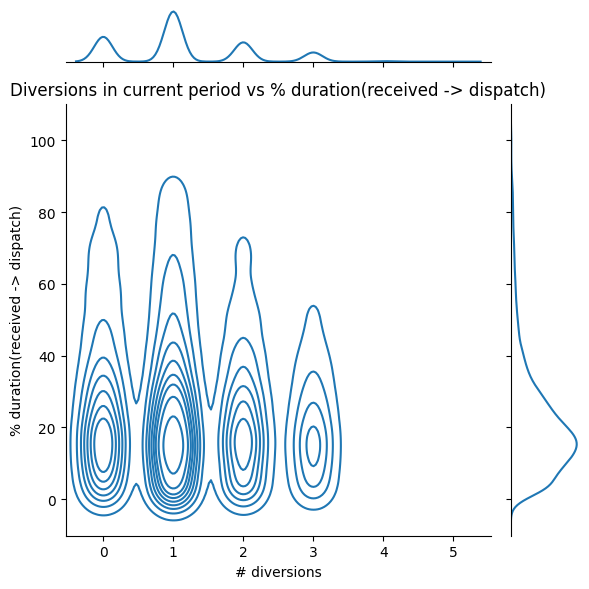

In [32]:
sns.jointplot(medic_sorted_with_diversions.sample(frac=0.2, random_state=0), x='diversion_count_curr',
             y='received_to_dispatch_perc', kind='kde');
plt.title('Diversions in current period vs % duration(received -> dispatch)');
plt.xlabel('# diversions');
plt.ylabel('% duration(received -> dispatch)');
plt.tight_layout()

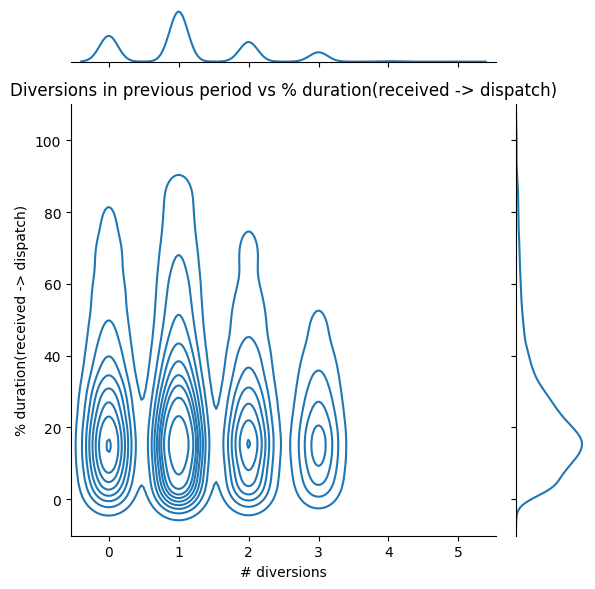

In [33]:
sns.jointplot(medic_sorted_with_diversions.sample(frac=0.2, random_state=0), x='diversion_count_prev',
             y='received_to_dispatch_perc', kind='kde');
plt.title('Diversions in previous period vs % duration(received -> dispatch)');
plt.xlabel('# diversions');
plt.ylabel('% duration(received -> dispatch)');
plt.tight_layout()

**Conclusion**: There doesn't seem to be evidence that hospital diversions affect subsequent call response times. Perhaps this is due to the number of hospitals in SF in general, meaning that even if 1 or more hospitals are on diversion status, there are still enough hospitals for ambulances to transport their patients to.

## Summary
56% of calls between Jan 2021 and Aug 2024 had a response time greater than 10 minutes. This response times varies across geographic regions and is particularly worse in the outer regions of SF. Response times are also fairly correlated with 911 call arrival rates, which are highest between roughly 10am and 6pm. On average, the first 20% of a response to a call is comprised of SFDEM receiving the call and dispatching a unit, and the other 80% is the SFFD ambulance getting to the scene after being dispatched by SFDEM.

### Recommendations
For only 8% of calls with slow responses, ambulances are dispatched before they are available. That means for the other 92%, the duration of the response time seems to be from SFDEM processing the call and dispatching a unit and the SFFD ambulance getting to the scene after being dispatched. Therefore, I'd recommend investigating the following:
- How SFDEM triages calls and decides whether to send an ambulance. Are there processes or technologies that could make this process more efficient?
- Can communication between SFDEM and SFFD and other ambulance providers be streamlines in order to dispatch ambulances faster?
- Do ambulances encounter issues on the road that slow them down while en route to the scene?
- Is the best choice being made when deciding on a particular ambulance to dispatch to a call?
- Could ambulances be stationed at more optimal places throughout the day in order to be closer to incoming calls?

I'll be exploring solutions to the last point by building a simulation of 911 medical calls and using reinforcement learning. Stay tuned!